In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import pandas as pd
import random
import re
import nltk
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from nltk.translate import AlignedSent, IBMModel1

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [4]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['il va s asseoir ici', 'he s going to sit here']


In [7]:
pairs[0]

['je vais bien', 'i m ok']

In [8]:
def clean_sentences(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        sentence = sentence.strip()
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-zA-Z0-9]+", " ", sentence)
        cleaned_sentences.append(sentence.strip())
    return cleaned_sentences

In [9]:
eng_sentence = []
fr_sentence = []

for pair in pairs:
    eng_sentence.append(pair[1])
    fr_sentence.append(pair[0])

In [10]:
eng_sentences = clean_sentences(eng_sentence)
fr_sentences = clean_sentences(fr_sentence)

In [11]:
#simple iteration
#def train_translation_model(source_sentences, target_sentences):
#    aligned_sentences = [AlignedSent(source.split(), target.split()) for source, target in zip(source_sentences, target_sentences)]
#    ibm_model = IBMModel1(aligned_sentences, 10)
#    return ibm_model
#
#translation_model = train_translation_model(fr_sentences, eng_sentences)

def train_translation_model(source_sentences, target_sentences, iterations):
    aligned_sentences = [AlignedSent(source.split(), target.split()) for source, target in zip(source_sentences, target_sentences)]
    ibm_model = IBMModel1(aligned_sentences, iterations)
    return ibm_model

In [12]:
def translate_sentence(ibm_model, sentence):
    cleaned_text = clean_sentences([sentence])[0]
    source_words = cleaned_text.split()
    translated_words = []
    for source_word in source_words:
        max_prob = 0.0
        translated_word = None
        for target_word in ibm_model.translation_table[source_word]:
            prob = ibm_model.translation_table[source_word][target_word]
            if prob > max_prob:
                max_prob = prob
                translated_word = target_word
        if translated_word is not None:
            translated_words.append(translated_word)
    translated_text = ' '.join(translated_words)
    return translated_text

In [13]:
#not for iteration
#def calculate_corpus_bleu_score(ibm_model, source_sentences, reference_sentences):
#    translated_sentences = [translate_sentence(ibm_model, sentence) for sentence in source_sentences]
#    reference_tokens = [[ref.split()] for ref in reference_sentences]
#    translated_tokens = [trans.split() for trans in translated_sentences]
#    bleu_score = corpus_bleu(reference_tokens, translated_tokens)
#    return bleu_score

def calculate_corpus_bleu_score(source_sentences, reference_sentences, translated_sentences):
    reference_tokens = [[ref.split()] for ref in reference_sentences]
    translated_tokens = [trans.split() for trans in translated_sentences]
    bleu_score = corpus_bleu(reference_tokens, translated_tokens)
    return bleu_score

In [14]:
iterations = 80
bleu_scores = []

# Train and evaluate the model for each iteration
for i in range(1, iterations + 1):
    ibm_model = train_translation_model(fr_sentences, eng_sentences, i)
    translated_sentences = [translate_sentence(ibm_model, sentence) for sentence in fr_sentences]
    bleu_score = calculate_corpus_bleu_score(fr_sentences, eng_sentences, translated_sentences)
    bleu_scores.append(bleu_score)
    print(f'Iteration {i}, BLEU score: {bleu_score}')

C:\Users\Neo\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Iteration 1, BLEU score: 9.357953449629124e-80
Iteration 2, BLEU score: 0.0512652966973991
Iteration 3, BLEU score: 0.08612004139886084
Iteration 4, BLEU score: 0.08724829072944654
Iteration 5, BLEU score: 0.08140656052049594
Iteration 6, BLEU score: 0.0818065882905302
Iteration 7, BLEU score: 0.08151929222804939
Iteration 8, BLEU score: 0.08144211418503321
Iteration 9, BLEU score: 0.08119028782477389
Iteration 10, BLEU score: 0.08117612715774986
Iteration 11, BLEU score: 0.08072245174349604
Iteration 12, BLEU score: 0.08102582800319312
Iteration 13, BLEU score: 0.08106734711429278
Iteration 14, BLEU score: 0.08114157514196184
Iteration 15, BLEU score: 0.08115755553984762
Iteration 16, BLEU score: 0.08115755553984762
Iteration 17, BLEU score: 0.08114627693319104
Iteration 18, BLEU score: 0.0811083243559264
Iteration 19, BLEU score: 0.0811083243559264
Iteration 20, BLEU score: 0.08110899002125144
Iteration 21, BLEU score: 0.08110634864897208
Iteration 22, BLEU score: 0.08093773037555149

In [15]:
def translate_input(ibm_model):
    while True:
        source_text = input("Enter the English sentence to translate (or 'q' to quit): ")
        if source_text.lower() == 'q':
            print("Quitting...")
            break
        cleaned_text = clean_sentences(source_text.split())
        source_words = cleaned_text
        translated_words = []
        for source_word in source_words:
            max_prob = 0.0
            translated_word = None
            for target_word in ibm_model.translation_table[source_word]:
                prob = ibm_model.translation_table[source_word][target_word]
                if prob > max_prob:
                    max_prob = prob
                    translated_word = target_word
            if translated_word is not None:
                translated_words.append(translated_word)
        translated_text = ' '.join(translated_words)
        print("Translated text:", translated_text,', ||avec proba:',{max_prob},'||')
        print()
translate_input(translation_model)

NameError: name 'translation_model' is not defined

In [25]:
def translate_input(ibm_model):
    while True:
        source_text = input("Enter the English sentence to translate (or 'q' to quit): ")
        if source_text.lower() == 'q':
            print("Quitting...")
            break
        cleaned_text = clean_sentences(source_text.split())
        source_words = cleaned_text
        translated_words = []
        for source_word in source_words:
            max_prob = 0.0
            translated_word = None
            for target_word in ibm_model.translation_table[source_word]:
                prob = ibm_model.translation_table[source_word][target_word]
                if prob > max_prob:
                    max_prob = prob
                    translated_word = target_word
            if translated_word is not None:
                translated_words.append(translated_word)
        translated_text = ' '.join(translated_words)
        print("Translated text:", translated_text,', ||avec proba:',{max_prob},'||')
        print()
translate_input(ibm_model)

Enter the English sentence to translate (or 'q' to quit): I
Translated text:  , ||avec proba: {0.0} ||

Enter the English sentence to translate (or 'q' to quit): je
Translated text: m , ||avec proba: {0.5973887369290085} ||

Enter the English sentence to translate (or 'q' to quit): je ne suis pas un doctor
Translated text: m don i t a , ||avec proba: {0.0} ||

Enter the English sentence to translate (or 'q' to quit): il
Translated text: he , ||avec proba: {0.9991930928021787} ||

Enter the English sentence to translate (or 'q' to quit): il est bien
Translated text: he is well , ||avec proba: {0.6555348497085084} ||

Enter the English sentence to translate (or 'q' to quit): enseignant
Translated text: staff , ||avec proba: {0.2000000000126121} ||

Enter the English sentence to translate (or 'q' to quit): tu
Translated text: you , ||avec proba: {0.28594943228794073} ||

Enter the English sentence to translate (or 'q' to quit): I
Translated text:  , ||avec proba: {0.0} ||

Enter the Engli

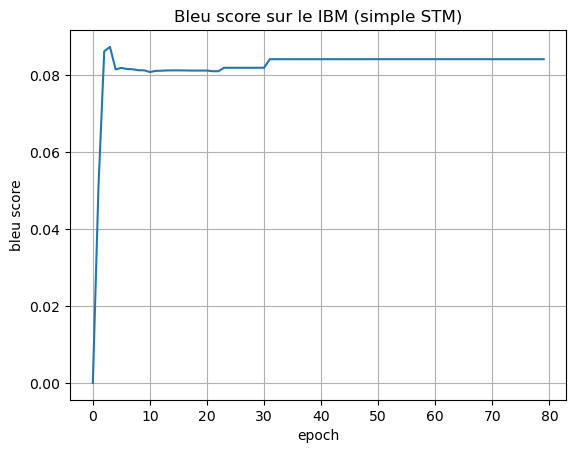

In [33]:
plt.plot(bleu_scores)
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.grid(True)
plt.title('Bleu score sur le IBM (simple STM)')
plt.savefig('STM BLEU scores.png', dpi = 300)